### raw data
* word embedding: glove
* doc text: ./data/IMDB.txt

### dataset
1. IMDB
2. CNNNews
3. [PubMed](https://github.com/LIAAD/KeywordExtractor-Datasets/blob/master/datasets/PubMed.zip)

### preprocess
1. filter too frequent and less frequent words
2. stemming
3. document vector aggregation

### model
1. TopK
2. Sklearn
3. Our model

### evaluation
1. F1
2. NDCG

In [1]:
from collections import defaultdict
import math
import numpy as np 
import re
import torch
import torch.nn as nn
from itertools import cycle
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from tqdm.auto import tqdm

# Used to get the data
from sklearn.metrics import ndcg_score

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
nltk.download('stopwords')

import matplotlib.pyplot as plt 
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/roytsai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocess config

In [2]:
config = {}

config["dataset"] = "IMDB" # "IMDB" "CNN", "PubMed"
config["n_document"] = 100
config["min_word_freq_threshold"] = 20
config["topk_word_freq_threshold"] = 300
config["document_vector_agg_weight"] = 'pmi' # ['mean', 'IDF', 'uniform', 'gaussian', 'exponential']
config["select_topk_TFIDF"] = None


In [3]:
# load word embedding
embedding_file = "../data/glove.6B.100d.txt"

word2embedding = dict()
word_dim = int(re.findall(r".(\d+)d",embedding_file)[0])

with open(embedding_file,"r") as f:
    for line in tqdm(f):
        line = line.strip().split()
        word = line[0]
        embedding = list(map(float,line[1:]))
        word2embedding[word] = embedding

print("Number of words:%d" % len(word2embedding))

0it [00:00, ?it/s]

Number of words:400000


In [4]:
config["document_vector_agg_weight"]

'pmi'

In [13]:
class Vocabulary:
    def __init__(self, word2embedding, min_word_freq_threshold=0, topk_word_freq_threshold=0):
        # The low frequency words will be assigned as <UNK> token
        self.itos = {0: "<UNK>"}
        self.stoi = {"<UNK>": 0}
        
        self.word2embedding = word2embedding
        self.min_word_freq_threshold = min_word_freq_threshold
        self.topk_word_freq_threshold = topk_word_freq_threshold
        
        self.word_freq_in_corpus = defaultdict(int)
        self.IDF = {}
        self.ps = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))

    def __len__(self):
        return len(self.itos)

#     @staticmethod
    def tokenizer_eng(self, text):
        text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
        text = text.strip().split()
        
        return [self.ps.stem(w) for w in text if w.lower() not in self.stop_words]

    def build_vocabulary(self, sentence_list):
        self.doc_freq = defaultdict(int) # # of document a word appear
        self.document_num = len(sentence_list)
        self.word_vectors = [[0]*word_dim] # unknown word emb
        
        for sentence in tqdm(sentence_list, desc="Preprocessing documents"):
            # for doc_freq
            document_words = set()
            
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.word2embedding:
                    continue
                    
                # calculate word freq
                self.word_freq_in_corpus[word] += 1
                document_words.add(word)
                
            for word in document_words:
                self.doc_freq[word] += 1
        
        # calculate IDF
        print('doc num', self.document_num)
        for word, freq in self.doc_freq.items():
            self.IDF[word] = math.log(self.document_num / (freq+1))
        
        # delete less freq words:
        delete_words = []
        for word, v in self.word_freq_in_corpus.items():
            if v < self.min_word_freq_threshold:
                delete_words.append(word)     
        for word in delete_words:
            del self.IDF[word]    
            del self.word_freq_in_corpus[word]    
        
        # delete too freq words
        print('eliminate freq words')
        IDF = [(word, freq) for word, freq in self.IDF.items()]
        IDF.sort(key=lambda x: x[1])

        for i in range(self.topk_word_freq_threshold):
#             print(word)
            word = IDF[i][0]
            del self.IDF[word]
            del self.word_freq_in_corpus[word]
        
        # construct word_vectors
        idx = 1
        for word in self.word_freq_in_corpus:
            self.word_vectors.append(self.word2embedding[word])
            self.stoi[word] = idx
            self.itos[idx] = word
            idx += 1
            
    def init_word_weight(self,sentence_list, agg):
        if agg == 'mean':
            self.word_weight = {word: 1 for word in self.IDF.keys()}
        elif agg == 'IDF':
            self.word_weight = self.IDF
        elif agg == 'uniform':
            self.word_weight = {word: np.random.uniform(low=0.0, high=1.0) for word in self.IDF.keys()}
        elif agg == 'gaussian':
            mu, sigma = 10, 1 # mean and standard deviation
            self.word_weight = {word: np.random.normal(mu, sigma) for word in self.IDF.keys()}
        elif agg == 'exponential':
            self.word_weight = {word: np.random.exponential(scale=1.0) for word in self.IDF.keys()}
        elif agg == 'pmi':
            trigram_measures = BigramAssocMeasures()
            self.word_weight = defaultdict(int)
            corpus = []

            for text in tqdm(sentence_list):
                corpus.extend(text.split())

            finder = BigramCollocationFinder.from_words(corpus)
            for pmi_score in finder.score_ngrams(trigram_measures.pmi):
                pair, score = pmi_score
                self.word_weight[pair[0]] += score
                self.word_weight[pair[1]] += score
    
    
    def calculate_document_vector(self, sentence_list, agg, n_document, select_topk_TFIDF=None):
        document_vectors = []
        document_answers = []
        document_answers_w = []
        self.init_word_weight(sentence_list, agg)

        for sentence in tqdm(sentence_list[:n_document], desc="calculate document vectors"):
            document_vector = np.zeros(len(self.word_vectors[0]))
            select_words = []
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.stoi:
                    continue
                else:
                    select_words.append(word)

            # select topk TDIDF
            if select_topk_TFIDF is not None:
                doc_TFIDF = defaultdict(float)
                for word in select_words:    
                    doc_TFIDF[word] += self.IDF[word]

                doc_TFIDF_l = [(word, TFIDF) for word, TFIDF in doc_TFIDF.items()]
                doc_TFIDF_l.sort(key=lambda x:x[1], reverse=True)
                
                select_topk_words = set(list(map(lambda x:x[0], doc_TFIDF_l[:select_topk_TFIDF])))
                select_words = [word for word in select_words if word in select_topk_words]
            else:
                pass
            
            total_weight = 0
            # aggregate to doc vectors
            for word in select_words:
                document_vector += np.array(self.word2embedding[word]) * self.word_weight[word]
                total_weight += self.word_weight[word]
                
            if len(select_words) == 0:
                print('error', sentence)
                continue
            else:
                document_vector /= total_weight
            
            document_vectors.append(document_vector)
            document_answers.append(select_words)
            document_answers_w.append(total_weight)
        
        # get answers
        document_answers_idx = []    
        for ans in document_answers:
            ans_idx = []
            for token in ans:
                if token in self.stoi:
                    ans_idx.append(self.stoi[token])                    
            document_answers_idx.append(ans_idx)
            
        return document_vectors, document_answers_idx, document_answers_w
        
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [14]:
class CBowDataset(Dataset):
    def __init__(self, 
                 raw_data_file_path,
                 word2embedding,
                 skip_header = False,
                 n_document = None, # read first n document
                 min_word_freq_threshold = 20, # eliminate less freq words
                 topk_word_freq_threshold = 5, # eliminate smallest k IDF words
                 select_topk_TFIDF = None, # select topk tf-idf as ground-truth
                 document_vector_agg_weight = 'mean',
                 ):

        assert document_vector_agg_weight in ['mean', 'IDF', 'uniform', 'gaussian', 'exponential', 'pmi']
        
        # raw documents
        self.documents = []
        
        with open(raw_data_file_path,'r',encoding='utf-8') as f:
            if skip_header:
                f.readline()
            for line in tqdm(f, desc="Loading documents"):
                # read firt n document
                # if n_document is not None and len(self.documents) >= n_document:
                #     break    
                self.documents.append(line.strip("\n"))

        # build vocabulary
        self.vocab = Vocabulary(word2embedding, min_word_freq_threshold, topk_word_freq_threshold)
        self.vocab.build_vocabulary(self.documents)
        self.vocab_size = len(self.vocab)

        # calculate document vectors
        self.document_vectors, self.document_answers, self.document_answers_w = self.vocab.calculate_document_vector(self.documents, \
                                                                                           document_vector_agg_weight, n_document, select_topk_TFIDF)
        # train-test split
        # training
        self.train_split_ratio = 0.8
        self.train_length = int(len(self.document_answers) * self.train_split_ratio)
        self.train_vectors = self.document_vectors[:self.train_length]
        self.train_words = self.document_answers[:self.train_length]
        self.document_ids = list(range(self.train_length))
        self.generator = cycle(self.context_target_generator())
        self.dataset_size = sum([len(s) for s in self.train_words])
        
        # testing
        self.test_vectors = self.document_vectors[self.train_length:]
        self.test_words = self.document_answers[self.train_length:]

    def context_target_generator(self):
        np.random.shuffle(self.document_ids) # inplace shuffle

        # randomly select a document and create its training example
        for document_id in self.document_ids: 
            word_list = set(self.train_words[document_id])
            negative_sample_space = list(set(range(self.vocab_size)) - word_list)
            negative_samples = np.random.choice(negative_sample_space,size=len(word_list),replace = False)
            for word_id, negative_wordID in zip(word_list, negative_samples):
                yield [document_id, word_id, negative_wordID]
                
    def __getitem__(self, idx):
        doc_id, word_id, negative_wordID = next(self.generator)
        doc_id = torch.FloatTensor(self.document_vectors[doc_id])
        word_id = torch.FloatTensor(self.vocab.word_vectors[word_id])
        negative_word = torch.FloatTensor(self.vocab.word_vectors[negative_wordID])

        return doc_id, word_id, negative_word

    def __len__(self):
        return self.dataset_size 


In [15]:
# load and build torch dataset
if config["dataset"] == 'IMDB':
    data_file_path = '../data/IMDB.txt'
elif config["dataset"] == 'CNN':
    data_file_path = '../data/CNN.txt'
elif config["dataset"] == 'PubMed':
    data_file_path = '../data/PubMed.txt'

print("Building dataset....")
dataset = CBowDataset(
                    raw_data_file_path=data_file_path,
                    word2embedding=word2embedding,
                    skip_header=False,
                    n_document = config["n_document"],
                    min_word_freq_threshold = config["min_word_freq_threshold"],
                    topk_word_freq_threshold = config["topk_word_freq_threshold"],
                    document_vector_agg_weight = config["document_vector_agg_weight"],
                    select_topk_TFIDF = config["select_topk_TFIDF"]
                    )
print("Finish building dataset!")
print(f"Number of documents:{len(dataset.documents)}")
print(f"Number of words:{dataset.vocab_size}")

Building dataset....


Loading documents: 0it [00:00, ?it/s]

Preprocessing documents:   0%|          | 0/100000 [00:00<?, ?it/s]

doc num 100000
eliminate freq words


  0%|          | 0/100000 [00:00<?, ?it/s]

calculate document vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Finish building dataset!
Number of documents:100000
Number of words:13776


In [17]:
# check test doc vectors' correctness
word_vectors = np.array(dataset.vocab.word_vectors)
word_vectors.shape

pred = np.zeros(100)
cnt = 0
for word_idx in dataset.test_words[0]:
    pred += word_vectors[word_idx] * dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
    cnt += dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
print(dataset.test_vectors[0] - pred/cnt)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [18]:
## create weight_ans
document_answers = dataset.document_answers

onehot_ans = np.zeros((len(document_answers), word_vectors.shape[0]))
weight_ans = np.zeros((len(document_answers), word_vectors.shape[0]))
print(weight_ans.shape)

for i in tqdm(range(len(document_answers))):
    for word_idx in document_answers[i]:
        weight_ans[i, word_idx] += dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
        onehot_ans[i, word_idx] += 1

(100, 13776)


  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
document_vectors = np.array(dataset.document_vectors)
document_answers_w = np.array(dataset.document_answers_w).reshape(-1, 1)

## setting training size

In [20]:
train_size_ratio = 1
train_size = int(len(dataset.document_answers) * train_size_ratio)
train_size

100

## Top K freq word

In [21]:
test_ans = dataset.document_answers[:train_size]

In [22]:
word_freq = [(word, freq) for word, freq in dataset.vocab.word_freq_in_corpus.items()]
word_freq.sort(key=lambda x:x[1], reverse=True)
word_freq[:10]

[('anim', 8207),
 ('women', 7375),
 ('game', 7072),
 ('sex', 7053),
 ('song', 7004),
 ('school', 6833),
 ('mother', 6781),
 ('mr', 6641),
 ('brother', 6406),
 ('joke', 6218)]

In [23]:
def topk_word_evaluation(k=50):
    topk_word = [word for (word, freq) in word_freq[:k]]

    pr, re = [], []
    for ans in tqdm(test_ans):
        ans = set(ans)
        ans = [dataset.vocab.itos[a] for a in ans]

        hit = []
        for word in ans:
            if word in topk_word:
                hit.append(word)

        precision = len(hit) / k
        recall = len(hit) / len(ans)
        pr.append(precision)
        re.append(recall)

    print('top {} word'.format(k))
    print('percision', np.mean(pr))
    print('recall', np.mean(re))

topk_word_evaluation(k=50)
topk_word_evaluation(k=100)
topk_word_evaluation(k=200)


  0%|          | 0/100 [00:00<?, ?it/s]

top 50 word
percision 0.05759999999999999
recall 0.08017600042587877


  0%|          | 0/100 [00:00<?, ?it/s]

top 100 word
percision 0.048400000000000006
recall 0.13917474669000185


  0%|          | 0/100 [00:00<?, ?it/s]

top 200 word
percision 0.04255
recall 0.2443217961696477


In [24]:
def topk_word_evaluation_NDCG(k=50):
    freq_word =[word for (word, freq) in word_freq]
    freq_word_idx = [dataset.vocab.stoi[word] for word in freq_word if word in dataset.vocab.stoi]
    
    scores = np.zeros(len(dataset.vocab.word_vectors))
    for rank, idx in enumerate(freq_word_idx):
        scores[idx] = len(dataset.vocab.word_vectors) - rank
    
    NDCGs = []
    
    for ans in tqdm(test_ans):
        weight_ans = np.zeros(len(dataset.vocab.word_vectors))
        
        for word_idx in ans:
            if word_idx == 0:
                continue
            word = dataset.vocab.itos[word_idx]
            weight_ans[word_idx] += dataset.vocab.IDF[word]

        NDCG_score = ndcg_score(weight_ans.reshape(1,-1), scores.reshape(1,-1), k=k)
        NDCGs.append(NDCG_score)

    print('top {} NDCG:{}'.format(k, np.mean(NDCGs)))

topk_word_evaluation_NDCG(k=50)
topk_word_evaluation_NDCG(k=100)
topk_word_evaluation_NDCG(k=200)
topk_word_evaluation_NDCG(k=None)


  0%|          | 0/100 [00:00<?, ?it/s]

top 50 NDCG:0.03822255111146626


  0%|          | 0/100 [00:00<?, ?it/s]

top 100 NDCG:0.05369637034259847


  0%|          | 0/100 [00:00<?, ?it/s]

top 200 NDCG:0.08397156401580595


  0%|          | 0/100 [00:00<?, ?it/s]

top None NDCG:0.2973493646494723


## Sklearn

In [25]:
from sklearn.linear_model import LinearRegression, Lasso

In [26]:
print(document_vectors.shape)
print(weight_ans.shape)
print(word_vectors.shape)

(100, 100)
(100, 13776)
(13776, 100)


In [27]:
def evaluate_sklearn(pred, ans):
    results = {}
        
    one_hot_ans = np.arange(ans.shape[0])[ans > 0]
    sorted_score = np.argsort(pred)
    for topk in [50, 100, 200]:
        one_hot_pred = sorted_score[-topk:]
        hit = np.intersect1d(one_hot_pred, one_hot_ans)
        percision = len(hit) / topk
        recall = len(hit) / len(one_hot_ans)
        
        results['F1@{}'.format(topk)] = 2 * percision * recall / (percision + recall)
        
    ans = ans.reshape(1, -1)
    pred = pred.reshape(1, -1)
    results['ndcg@50'] = (ndcg_score(ans, pred, k=50))
    results['ndcg@100'] = (ndcg_score(ans, pred, k=100))
    results['ndcg@200'] = (ndcg_score(ans, pred, k=200))
    results['ndcg@all'] = (ndcg_score(ans, pred, k=None))
    
    return results

### linear regression

In [28]:
results = []

for doc_id, doc_emb in enumerate(tqdm(document_vectors[:train_size])):
    x = word_vectors.T
    y = doc_emb
    
    ans = weight_ans[doc_id]
    model = LinearRegression(fit_intercept=False,n_jobs=-1).fit(x, y)
    r2 = model.score(x, y)

    res = evaluate_sklearn(model.coef_, ans)
    res['R2'] = r2
    results.append(res)

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
results = pd.DataFrame(results)
results.mean()

F1@50       0.155926
F1@100      0.122731
F1@200      0.093248
ndcg@50     0.587723
ndcg@100    0.609504
ndcg@200    0.634676
ndcg@all    0.709010
R2          1.000000
dtype: float64

In [30]:
results = []

for doc_id, doc_emb in enumerate(tqdm(document_vectors[:train_size])):
    x = word_vectors.T
    y = doc_emb
    
    ans = weight_ans[doc_id]
    model = Lasso(positive=True, fit_intercept=False, alpha=0.0001, max_iter=10000).fit(x, y)
    r2 = model.score(x, y)

    res = evaluate_sklearn(model.coef_, ans)
    res['R2'] = r2
    results.append(res)

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
results = pd.DataFrame(results)
results.mean()

F1@50       0.359813
F1@100      0.242295
F1@200      0.141421
ndcg@50     0.885713
ndcg@100    0.893371
ndcg@200    0.894711
ndcg@all    0.924910
R2          0.999995
dtype: float64

In [32]:
results = []

for doc_id, doc_emb in enumerate(tqdm(document_vectors[:train_size])):
    x = word_vectors.T
    y = doc_emb
    
    ans = weight_ans[doc_id]
    model = Lasso(positive=False, fit_intercept=False, alpha=0.0001, max_iter=10000, tol=1e-4).fit(x, y)
    r2 = model.score(x, y)

    res = evaluate_sklearn(model.coef_, ans)
    res['R2'] = r2
    results.append(res)

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
results = pd.DataFrame(results)
results.mean()

F1@50       0.354707
F1@100      0.237450
F1@200      0.138297
ndcg@50     0.881697
ndcg@100    0.888987
ndcg@200    0.890270
ndcg@all    0.921392
R2          0.999996
dtype: float64

## Our Model

In [34]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [35]:
class Custom_Dataset(Dataset):
    def __init__(self, 
                 doc_vectors,
                 doc_w_sum,
                 weight_ans
                 ):
        self.doc_vectors = torch.FloatTensor(doc_vectors)
        self.doc_w_sum = torch.FloatTensor(doc_w_sum)
        self.weight_ans = weight_ans
        assert len(doc_vectors) == len(doc_w_sum)
        
    def __getitem__(self, idx):
                
        return self.doc_vectors[idx], self.doc_w_sum[idx], idx

    def __len__(self):
        return len(self.doc_vectors)


In [36]:
class LR(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, num_doc, num_words):
        super(LR, self).__init__()
        weight = torch.zeros(num_doc, num_words).to(device)
        self.emb = torch.nn.Embedding.from_pretrained(weight, freeze=False)
        
    def forward(self, doc_ids, word_vectors):
        return self.emb(doc_ids) @ word_vectors

In [37]:
def evaluate_NDCG(model, train_loader):
    results = {}
    model.eval()
    
    scores = np.array(model.emb.cpu().weight.data)
    model.emb.to(device)
    true_relevance = train_loader.dataset.weight_ans

    # F1
    F1s = []
    for i in range(true_relevance.shape[0]):
        one_hot_ans = np.arange(true_relevance.shape[1])[true_relevance[i] > 0]
        pred = scores[i]
        
        F1 = []
        for topk in [50, 100, 200]:
            one_hot_pred = np.argsort(pred)[-topk:]
            
            hit = np.intersect1d(one_hot_pred, one_hot_ans)
            percision = len(hit) / topk
            recall = len(hit) / len(one_hot_ans)
            
            ans = 2 * percision * recall / (percision + recall) if (percision + recall) > 0 else 0
            F1.append(ans)
        F1s.append(F1)
        
    F1s = np.mean(F1s, axis=0)
    results['F1@50'] = F1s[0]
    results['F1@100'] = F1s[1]
    results['F1@200'] = F1s[2]

    # NDCG
    results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
    results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
    results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
    results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))
    
    return results

In [38]:
batch_size = 100

# train_size_ratio = 1
# train_size = int(len(dataset.document_vectors) * train_size_ratio)
print('document num', train_size)

train_dataset = Custom_Dataset(document_vectors[:train_size], document_answers_w[:train_size], weight_ans[:train_size])
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

document num 100


## start training

In [ ]:
# setting
lr = 0.1
momentum = 0.99
weight_decay = 0
nesterov = False # True

n_epoch = 50000

w_sum_reg = 1e-3
w_sum_reg_mul = 0.9
w_clip_value = 0

L1 = 1e-6

verbose = True
valid_epoch = 100

model = LR(num_doc=train_size, num_words=word_vectors.shape[0]).to(device)
model.train()

word_vectors_tensor = torch.FloatTensor(word_vectors).to(device)
w_reg = (torch.ones(batch_size, 1) * w_sum_reg_mul).to(device)
    
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
criterion = nn.MSELoss(reduction='mean')

results = []
step = 0
for epoch in tqdm(range(n_epoch)):    
    loss_mse_his = []
    loss_w_reg_his = []
    
    model.train()

    for data in train_loader:
        doc_embs, doc_w_sum, doc_ids = data
        
        doc_embs = doc_embs.to(device)
        doc_w_sum = doc_w_sum.to(device)
        doc_ids = doc_ids.to(device)
        
        # MSE loss
        pred_doc_embs = model(doc_ids, word_vectors_tensor)     
        loss_mse = criterion(pred_doc_embs, doc_embs)

        pred_w_sum = torch.sum(model.emb(doc_ids), axis=1).view(-1, 1)
        loss_w_reg = criterion(pred_w_sum, w_reg)
        
        loss_l1 = torch.sum(torch.abs(model.emb(doc_ids)))
        loss = loss_mse + loss_w_reg * w_sum_reg + loss_l1 * L1
        
        # Model backwarding
        model.zero_grad()
        loss.backward()
        opt.step()

        loss_mse_his.append(loss_mse.item())
        loss_w_reg_his.append(loss_w_reg.item())

        for p in model.parameters():
            p.data.clamp_(w_clip_value, float('inf'))

        
    if epoch % valid_epoch == 0:
        res = {}
        res['epoch'] = epoch
        res['loss_mse'] = np.mean(loss_mse_his)
        res['loss_w_reg'] = np.mean(loss_w_reg_his)
        
        res_ndcg = evaluate_NDCG(model, train_loader)
        res.update(res_ndcg)
        results.append(res)
        
        print()
        if verbose:
            for k, v in res.items():
                print(k, v)

    results.append(res)

  0%|          | 0/50000 [00:00<?, ?it/s]


epoch 0
loss_mse 0.11073683947324753
loss_w_reg 0.8099998831748962
F1@50 0.08297006493517081
F1@100 0.07884409606302908
F1@200 0.07095721235505312
ndcg@50 0.2804240582611195
ndcg@100 0.3133975182571971
ndcg@200 0.352406382795738
ndcg@all 0.45333680473921717

epoch 100
loss_mse 0.00014457019278779626
loss_w_reg 0.2603953778743744
F1@50 0.19388370596753282
F1@100 0.14592893249428307
F1@200 0.10486585006393408
ndcg@50 0.6847864540697814
ndcg@100 0.7012712699190977
ndcg@200 0.7219014908211642
ndcg@all 0.7814897336843305

epoch 200
loss_mse 3.3992175303865224e-05
loss_w_reg 0.14323930442333221
F1@50 0.20652498814869322
F1@100 0.1551986448041857
F1@200 0.10994989926665204
ndcg@50 0.7205812820937162
ndcg@100 0.7381163401659028
ndcg@200 0.7565443625849327
ndcg@all 0.8095181361100999

epoch 300
loss_mse 1.8762031686492264e-05
loss_w_reg 0.10479390621185303
F1@50 0.21283333574790628
F1@100 0.15826337998378295
F1@200 0.11254335275957389
ndcg@50 0.7361835857608618
ndcg@100 0.7518049450429346
ndcg


epoch 3200
loss_mse 1.893357875815127e-06
loss_w_reg 0.012816350907087326
F1@50 0.2625768208137332
F1@100 0.19087162740465202
F1@200 0.13268998095675638
ndcg@50 0.8181855814037269
ndcg@100 0.8316673908461931
ndcg@200 0.8489593423950648
ndcg@all 0.8866812677138799

epoch 3300
loss_mse 1.8346847809880273e-06
loss_w_reg 0.012406636960804462
F1@50 0.2641385469963106
F1@100 0.19109302801013567
F1@200 0.133667527790316
ndcg@50 0.8200689421071133
ndcg@100 0.8332710757645065
ndcg@200 0.8510820667231183
ndcg@all 0.8885220661390093

epoch 3400
loss_mse 1.782827439456014e-06
loss_w_reg 0.012019743211567402
F1@50 0.2651895845842524
F1@100 0.1919192754814548
F1@200 0.1340901428282732
ndcg@50 0.820822033678514
ndcg@100 0.8343275889543412
ndcg@200 0.8521978370437268
ndcg@all 0.8894535967529552

epoch 3500
loss_mse 1.7338977613690076e-06
loss_w_reg 0.011657739989459515
F1@50 0.26618800910036844
F1@100 0.1927446281912339
F1@200 0.1341299729959361
ndcg@50 0.8219988994504068
ndcg@100 0.8355888867043262



epoch 6300
loss_mse 1.0494527487026062e-06
loss_w_reg 0.006886791903525591
F1@50 0.2872247960180602
F1@100 0.20694939134580254
F1@200 0.1425296038850866
ndcg@50 0.8407531648744561
ndcg@100 0.8543865465149361
ndcg@200 0.8703276142654921
ndcg@all 0.9042548085471046

epoch 6400
loss_mse 1.0379455943620997e-06
loss_w_reg 0.006811492145061493
F1@50 0.28838696206956266
F1@100 0.2074259467189096
F1@200 0.1421529884197876
ndcg@50 0.8413112642258599
ndcg@100 0.8548681751310043
ndcg@200 0.8701852942549592
ndcg@all 0.9043780146744003

epoch 6500
loss_mse 1.0267508514516521e-06
loss_w_reg 0.006739150267094374
F1@50 0.2892717023293029
F1@100 0.20830384428964102
F1@200 0.14261629042472437
ndcg@50 0.8417553546632335
ndcg@100 0.8554357972681504
ndcg@200 0.8709056342868311
ndcg@all 0.9043996648027242

epoch 6600
loss_mse 1.0169517281610752e-06
loss_w_reg 0.006668625865131617
F1@50 0.29028644491473343
F1@100 0.208598467945555
F1@200 0.14235581960634136
ndcg@50 0.8423614618431882
ndcg@100 0.855907539631


epoch 9500
loss_mse 8.060700906753482e-07
loss_w_reg 0.005484999157488346
F1@50 0.3071785257888839
F1@100 0.21843972061971986
F1@200 0.14513712418483504
ndcg@50 0.8533468225251098
ndcg@100 0.866395471039727
ndcg@200 0.8792540565410204
ndcg@all 0.912241526356296

epoch 9600
loss_mse 8.020892323656881e-07
loss_w_reg 0.005462071858346462
F1@50 0.3070888050521043
F1@100 0.2188216873454445
F1@200 0.1446891026089531
ndcg@50 0.8533569405308897
ndcg@100 0.8666493504409454
ndcg@200 0.8792275724910428
ndcg@all 0.9123673051226029

epoch 9700
loss_mse 7.979957103998458e-07
loss_w_reg 0.005440022796392441
F1@50 0.30725409430830264
F1@100 0.2190983119568231
F1@200 0.14530247727884352
ndcg@50 0.8535168516190217
ndcg@100 0.8668069580467899
ndcg@200 0.8800245056588838
ndcg@all 0.9126453781812556

epoch 9800
loss_mse 7.939718216221081e-07
loss_w_reg 0.005418724380433559
F1@50 0.30725409430830264
F1@100 0.21911189607385548
F1@200 0.1452452688021699
ndcg@50 0.8536642170755594
ndcg@100 0.8669006891517732



epoch 12600
loss_mse 7.199594733720005e-07
loss_w_reg 0.004999131895601749
F1@50 0.31665437683799835
F1@100 0.22311962435941354
F1@200 0.1478549698467886
ndcg@50 0.8603239779307803
ndcg@100 0.8718781858155062
ndcg@200 0.8854749346617907
ndcg@all 0.9169063589998749

epoch 12700
loss_mse 7.182416652540269e-07
loss_w_reg 0.004988564178347588
F1@50 0.31696687683799835
F1@100 0.22318117785233
F1@200 0.1473542153707259
ndcg@50 0.8604566228546053
ndcg@100 0.8720392299071104
ndcg@200 0.8847377322202798
ndcg@all 0.9168530420349725

epoch 12800
loss_mse 7.163779400798376e-07
loss_w_reg 0.004978304263204336
F1@50 0.3175074173785389
F1@100 0.22312422387317923
F1@200 0.14917969029477687
ndcg@50 0.8607376480027802
ndcg@100 0.87223031349559
ndcg@200 0.8860380426903118
ndcg@all 0.9175332000015639

epoch 12900
loss_mse 7.148238410081831e-07
loss_w_reg 0.004968068562448025
F1@50 0.31896174376911085
F1@100 0.22329813691665748
F1@200 0.14852891277744745
ndcg@50 0.8611648147236288
ndcg@100 0.8723451875358


epoch 15700
loss_mse 6.682122943857394e-07
loss_w_reg 0.0047628614120185375
F1@50 0.3274610331087255
F1@100 0.22817060683354795
F1@200 0.1498205814966768
ndcg@50 0.8661366430991074
ndcg@100 0.8763427671040237
ndcg@200 0.8888216036654794
ndcg@all 0.9199977045148151

epoch 15800
loss_mse 6.66835774154606e-07
loss_w_reg 0.00475753378123045
F1@50 0.3280095405714121
F1@100 0.22851103852991195
F1@200 0.1496162774790875
ndcg@50 0.8663642077011272
ndcg@100 0.8764650503666815
ndcg@200 0.8891674331267799
ndcg@all 0.9198631250314344

epoch 15900
loss_mse 6.656324558207416e-07
loss_w_reg 0.0047522238455712795
F1@50 0.32832204057141207
F1@100 0.22867632778611027
F1@200 0.15011587135280416
ndcg@50 0.8664849695587306
ndcg@100 0.8766429000419496
ndcg@200 0.888798875931278
ndcg@all 0.9198357804498343

epoch 16000
loss_mse 6.641786285399576e-07
loss_w_reg 0.0047471784055233
F1@50 0.32876814564387585
F1@100 0.22850538761517003
F1@200 0.1501610423392822
ndcg@50 0.8667341744219413
ndcg@100 0.8767258855862


epoch 18800
loss_mse 6.309284117378411e-07
loss_w_reg 0.004643860273063183
F1@50 0.3346168701472076
F1@100 0.2300997767822296
F1@200 0.15025267964829422
ndcg@50 0.8698060617620179
ndcg@100 0.8788728973047369
ndcg@200 0.8910549248746966
ndcg@all 0.9222593276047725

epoch 18900
loss_mse 6.298820380834513e-07
loss_w_reg 0.004641307517886162
F1@50 0.3346168701472076
F1@100 0.23026106710481023
F1@200 0.15229482844217546
ndcg@50 0.8698384586567401
ndcg@100 0.8790296442229399
ndcg@200 0.8924162523623376
ndcg@all 0.9226215918755074

epoch 19000
loss_mse 6.288884151217644e-07
loss_w_reg 0.004638804122805595
F1@50 0.33489856028805265
F1@100 0.23037941030007653
F1@200 0.15151331346235583
ndcg@50 0.8700588550929855
ndcg@100 0.8791598464849002
ndcg@200 0.8921203468556912
ndcg@all 0.9224187436609931

epoch 19100
loss_mse 6.280218372012314e-07
loss_w_reg 0.0046363151632249355
F1@50 0.33487379248619503
F1@100 0.23052433783630838
F1@200 0.1524276972536401
ndcg@50 0.870067677775102
ndcg@100 0.879262292


epoch 21900
loss_mse 6.059164547878026e-07
loss_w_reg 0.0045891255140304565
F1@50 0.33933123566119616
F1@100 0.23270191560803458
F1@200 0.15169813698035559
ndcg@50 0.8723356817726731
ndcg@100 0.8811930433157174
ndcg@200 0.8934431225076709
ndcg@all 0.9236007351320107

epoch 22000
loss_mse 6.054396521903982e-07
loss_w_reg 0.00458794878795743
F1@50 0.33933123566119616
F1@100 0.23285816560803457
F1@200 0.15145163288686167
ndcg@50 0.8723623477706945
ndcg@100 0.881344710388236
ndcg@200 0.8936301032431954
ndcg@all 0.9236657492541583

epoch 22100
loss_mse 6.049052103662689e-07
loss_w_reg 0.0045868027955293655
F1@50 0.3391312356611962
F1@100 0.23285816560803457
F1@200 0.15108530252890875
ndcg@50 0.8722767918906478
ndcg@100 0.881336407641176
ndcg@200 0.8931504798222177
ndcg@all 0.9235541336077163

epoch 22200
loss_mse 6.044781457603676e-07
loss_w_reg 0.004585606977343559
F1@50 0.3391312356611962
F1@100 0.23285816560803457
F1@200 0.15089221014797935
ndcg@50 0.872299754681402
ndcg@100 0.881363453


epoch 25000
loss_mse 5.955043320682307e-07
loss_w_reg 0.004559733904898167
F1@50 0.3416749271304114
F1@100 0.23369745528694136
F1@200 0.15267906955502974
ndcg@50 0.8739270995321153
ndcg@100 0.8827492974821571
ndcg@200 0.8954698267559138
ndcg@all 0.9250832722919625

epoch 25100
loss_mse 5.952320520918875e-07
loss_w_reg 0.00455906568095088
F1@50 0.3416749271304114
F1@100 0.2338513014407875
F1@200 0.15216159388794628
ndcg@50 0.8739449870333751
ndcg@100 0.8828361147834967
ndcg@200 0.895211407279997
ndcg@all 0.9247929307545865

epoch 25200
loss_mse 5.95007634274225e-07
loss_w_reg 0.0045583657920360565
F1@50 0.34218261943810374
F1@100 0.23370844429793036
F1@200 0.15203901077465065
ndcg@50 0.8740729361412656
ndcg@100 0.8827396000781431
ndcg@200 0.8946565877131022
ndcg@all 0.924781207809853

epoch 25300
loss_mse 5.947291583652259e-07
loss_w_reg 0.004557721316814423
F1@50 0.3420008012562856
F1@100 0.23374047069544587
F1@200 0.15178609264029688
ndcg@50 0.8740400310381734
ndcg@100 0.882787793200


epoch 28100
loss_mse 5.897504706808832e-07
loss_w_reg 0.004541902337223291
F1@50 0.34379092572933023
F1@100 0.2340272697344361
F1@200 0.151936734262293
ndcg@50 0.875509875936255
ndcg@100 0.883677707297266
ndcg@200 0.8952927787677052
ndcg@all 0.9252932856031763

epoch 28200
loss_mse 5.896542347727518e-07
loss_w_reg 0.004541406407952309
F1@50 0.34379092572933023
F1@100 0.23419255899063443
F1@200 0.1529924023102026
ndcg@50 0.8755296461290294
ndcg@100 0.8837399393768421
ndcg@200 0.8964827612794104
ndcg@all 0.9258406657912083

epoch 28300
loss_mse 5.894935952710512e-07
loss_w_reg 0.0045409551821649075
F1@50 0.34379092572933023
F1@100 0.23419255899063443
F1@200 0.15225798835076898
ndcg@50 0.8755978656396729
ndcg@100 0.883808994025719
ndcg@200 0.89619812343954
ndcg@all 0.9257905344860258

epoch 28400
loss_mse 5.894042942600208e-07
loss_w_reg 0.0045404620468616486
F1@50 0.34379092572933023
F1@100 0.23418475004939673
F1@200 0.15073286065671448
ndcg@50 0.8755918182547754
ndcg@100 0.883793850739


epoch 31200
loss_mse 5.855641802554601e-07
loss_w_reg 0.004529723897576332
F1@50 0.3454825939064938
F1@100 0.23597366787771076
F1@200 0.1533734727991987
ndcg@50 0.877175951987043
ndcg@100 0.8855406461877509
ndcg@200 0.8976291589597352
ndcg@all 0.9272294276835865

epoch 31300
loss_mse 5.854357709722535e-07
loss_w_reg 0.004529417026787996
F1@50 0.34520862130375407
F1@100 0.2361389571339091
F1@200 0.15238813906669066
ndcg@50 0.8770519454999185
ndcg@100 0.8856026750714928
ndcg@200 0.8972845461288734
ndcg@all 0.9270332920388153

epoch 31400
loss_mse 5.85339194003609e-07
loss_w_reg 0.004529080353677273
F1@50 0.34520862130375407
F1@100 0.23597366787771076
F1@200 0.15146250004203862
ndcg@50 0.8771011309689162
ndcg@100 0.8856121916423958
ndcg@200 0.8966229735516765
ndcg@all 0.9269464789738838

epoch 31500
loss_mse 5.852324420629884e-07
loss_w_reg 0.004528741352260113
F1@50 0.34506047315560595
F1@100 0.23597366787771076
F1@200 0.15178559033816097
ndcg@50 0.8768442807627779
ndcg@100 0.8856176475


epoch 34300
loss_mse 5.816131647407019e-07
loss_w_reg 0.004521199502050877
F1@50 0.3460965109737053
F1@100 0.23725433566971707
F1@200 0.1524712503085107
ndcg@50 0.8776028202091066
ndcg@100 0.8865758273603517
ndcg@200 0.8980662870911766
ndcg@all 0.9278959957857539

epoch 34400
loss_mse 5.81530628096516e-07
loss_w_reg 0.004520947113633156
F1@50 0.3460965109737053
F1@100 0.23725433566971707
F1@200 0.15326631461011894
ndcg@50 0.8776108826058272
ndcg@100 0.8865864043356431
ndcg@200 0.8983117537306708
ndcg@all 0.927935964708212

epoch 34500
loss_mse 5.814162591377681e-07
loss_w_reg 0.004520717076957226
F1@50 0.3460965109737053
F1@100 0.23726973114088262
F1@200 0.15302102498183445
ndcg@50 0.8776222412827529
ndcg@100 0.8866154038989345
ndcg@200 0.8978527805205289
ndcg@all 0.9276834892732793

epoch 34600
loss_mse 5.813141115140752e-07
loss_w_reg 0.0045204926282167435
F1@50 0.3460965109737053
F1@100 0.23710166391399187
F1@200 0.15206082899641138
ndcg@50 0.8776241722970081
ndcg@100 0.88658512047


epoch 37400
loss_mse 5.785103098787658e-07
loss_w_reg 0.004514541942626238
F1@50 0.3468614378501585
F1@100 0.2373481801026477
F1@200 0.15308772748782093
ndcg@50 0.8782878065703967
ndcg@100 0.8867353489744042
ndcg@200 0.8983419452600616
ndcg@all 0.9279534666607242

epoch 37500
loss_mse 5.784013978882285e-07
loss_w_reg 0.004514371510595083
F1@50 0.34713541045289825
F1@100 0.23748611113713042
F1@200 0.15220970331540043
ndcg@50 0.8784276514236964
ndcg@100 0.8867702223224266
ndcg@200 0.8980181647058803
ndcg@all 0.9279923793581049

epoch 37600
loss_mse 5.782837888546055e-07
loss_w_reg 0.004514186177402735
F1@50 0.34703178350989305
F1@100 0.23763878289285562
F1@200 0.1519146349583593
ndcg@50 0.8784161489422694
ndcg@100 0.8867900939519341
ndcg@200 0.8977872980067868
ndcg@all 0.9279397932235461

epoch 37700
loss_mse 5.781950562777638e-07
loss_w_reg 0.004514002241194248
F1@50 0.34703178350989305
F1@100 0.2376541783640212
F1@200 0.15294182555887365
ndcg@50 0.8784146819379122
ndcg@100 0.886806788


epoch 40500
loss_mse 5.750902118961676e-07
loss_w_reg 0.004509903024882078
F1@50 0.34766754990228693
F1@100 0.23789298352432645
F1@200 0.1529819439313212
ndcg@50 0.8789383735536869
ndcg@100 0.8869587855947568
ndcg@200 0.8985495771097137
ndcg@all 0.9283424123969527

epoch 40600
loss_mse 5.749939759880363e-07
loss_w_reg 0.004509755410254002
F1@50 0.34766754990228693
F1@100 0.23742757584261492
F1@200 0.1533978893012591
ndcg@50 0.8789470054210698
ndcg@100 0.8868764846892557
ndcg@200 0.8992828117337157
ndcg@all 0.9284694043587978

epoch 40700
loss_mse 5.748104285885347e-07
loss_w_reg 0.004509705118834972
F1@50 0.34766754990228693
F1@100 0.23743238440185038
F1@200 0.15351716685023445
ndcg@50 0.8789564974059852
ndcg@100 0.8868911856998253
ndcg@200 0.8987529626269134
ndcg@all 0.9281406490348358

epoch 40800
loss_mse 5.747294835600769e-07
loss_w_reg 0.00450954819098115
F1@50 0.34766754990228693
F1@100 0.23758505615757555
F1@200 0.1520766963600462
ndcg@50 0.878963762898787
ndcg@100 0.8869193193


epoch 43600
loss_mse 5.722652076656232e-07
loss_w_reg 0.004506808239966631
F1@50 0.3491339833279554
F1@100 0.2378824385380268
F1@200 0.15433102567928125
ndcg@50 0.8794454462185161
ndcg@100 0.887128457930331
ndcg@200 0.8994029053906641
ndcg@all 0.9281749758283014

epoch 43700
loss_mse 5.722167770727538e-07
loss_w_reg 0.004506719298660755
F1@50 0.34939039358436574
F1@100 0.23799293577559585
F1@200 0.15279071268499816
ndcg@50 0.8794865584603221
ndcg@100 0.8873099312446584
ndcg@200 0.8983563947709008
ndcg@all 0.9282848750116891

epoch 43800
loss_mse 5.721241791434295e-07
loss_w_reg 0.004506652243435383
F1@50 0.34939039358436574
F1@100 0.23800352268752598
F1@200 0.15347015015782278
ndcg@50 0.8794984556652351
ndcg@100 0.887334608506389
ndcg@200 0.8989568320875762
ndcg@all 0.9285037156093077

epoch 43900
loss_mse 5.72113378893846e-07
loss_w_reg 0.004506539087742567
F1@50 0.34939039358436574
F1@100 0.2381610030024866
F1@200 0.15277126127984694
ndcg@50 0.8795351350525855
ndcg@100 0.88739534081

,loss_mse,loss_w_reg,F1@50,F1@100,F1@200,ndcg@50,ndcg@100,ndcg@200,ndcg@all
epoch,,,,,,,,,
49500,5.691791e-07,0.004504,0.350371,0.238813,0.152960,0.880342,0.888139,0.899517,0.928952
49600,5.692097e-07,0.004504,0.350371,0.238813,0.152637,0.880340,0.888137,0.898845,0.928680
49700,5.691973e-07,0.004504,0.350371,0.238813,0.152919,0.880340,0.888139,0.899427,0.928871
49800,5.690962e-07,0.004504,0.350371,0.238645,0.152939,0.880332,0.888114,0.899167,0.928877
49900,5.691603e-07,0.004504,0.350371,0.238987,0.152112,0.880350,0.888272,0.898776,0.928936


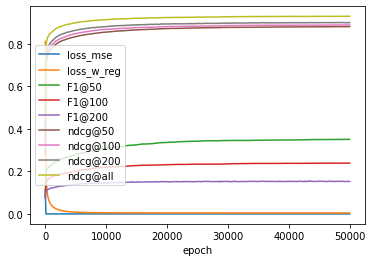

In [41]:
pd.set_option('display.max_rows', 500)
results_df = pd.DataFrame(results)
results_df.groupby(by=['epoch']).mean().plot()
results_df.groupby(by=['epoch']).mean().tail()
# results_df.groupby(by=['epoch']).mean().iloc[-1]

In [42]:
# setting
lr = 0.5
momentum = 0.99
weight_decay = 0
nesterov = False # True

milestones = [5000, 1000, 15000]
gamma = 0.1

n_epoch = 50000

w_sum_reg = 1e-3
w_sum_reg_mul = 0.9
w_clip_value = 0


L1 = 1e-6

verbose = True
valid_epoch = 100


model = LR(num_doc=train_size, num_words=word_vectors.shape[0]).to(device)
model.train()

word_vectors_tensor = torch.FloatTensor(word_vectors).to(device)
w_reg = (torch.ones(batch_size, 1) * w_sum_reg_mul).to(device)
    
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
scheduler = MultiStepLR(opt, milestones=milestones, gamma=gamma)

criterion = nn.MSELoss(reduction='mean')

results = []
step = 0
for epoch in tqdm(range(n_epoch)):    
    loss_mse_his = []
    loss_w_reg_his = []
    
    model.train()

    for data in train_loader:
        doc_embs, doc_w_sum, doc_ids = data
        
        doc_embs = doc_embs.to(device)
        doc_w_sum = doc_w_sum.to(device)
        doc_ids = doc_ids.to(device)
        # MSE loss
        pred_doc_embs = model(doc_ids, word_vectors_tensor)     
        loss_mse = criterion(pred_doc_embs, doc_embs)

        pred_w_sum = torch.sum(model.emb(doc_ids), axis=1).view(-1, 1)
        loss_w_reg = criterion(pred_w_sum, w_reg)
        
        loss_l1 = torch.sum(torch.abs(model.emb(doc_ids)))
        loss = loss_mse + loss_w_reg * w_sum_reg + loss_l1 * L1
        
        # Model backwarding
        model.zero_grad()
        loss.backward()
        opt.step()
        
        loss_mse_his.append(loss_mse.item())
        loss_w_reg_his.append(loss_w_reg.item())

        for p in model.parameters():
            p.data.clamp_(w_clip_value, float('inf'))

        
    if epoch % valid_epoch == 0:
        res = {}
        res['epoch'] = epoch
        res['loss_mse'] = np.mean(loss_mse_his)
        res['loss_w_reg'] = np.mean(loss_w_reg_his)
        
        res_ndcg = evaluate_NDCG(model, train_loader)
        res.update(res_ndcg)
        results.append(res)
        
        print()
        if verbose:
            for k, v in res.items():
                print(k, v)
                
    results.append(res)
    scheduler.step()

  0%|          | 0/50000 [00:00<?, ?it/s]


epoch 0
loss_mse 0.11073683947324753
loss_w_reg 0.8099998831748962
F1@50 0.08297006493517081
F1@100 0.07884409606302908
F1@200 0.07095721235505312
ndcg@50 0.2804240582611195
ndcg@100 0.3133975182571971
ndcg@200 0.352406382795738
ndcg@all 0.45333680473921717

epoch 100
loss_mse 4.088006608071737e-05
loss_w_reg 0.10101516544818878
F1@50 0.21182998434660713
F1@100 0.15927132687558707
F1@200 0.11312505782327907
ndcg@50 0.7365999375279394
ndcg@100 0.7537679792310996
ndcg@200 0.7715086348293073
ndcg@all 0.8212443542532033

epoch 200
loss_mse 1.0758666576293763e-05
loss_w_reg 0.04773237928748131
F1@50 0.22738913060659904
F1@100 0.16969195784030922
F1@200 0.11949003286639004
ndcg@50 0.7688011729867972
ndcg@100 0.784821658959486
ndcg@200 0.8023785583007091
ndcg@all 0.8470224780822316

epoch 300
loss_mse 5.117231467011152e-06
loss_w_reg 0.02920355275273323
F1@50 0.2402645838512351
F1@100 0.179334420611028
F1@200 0.12482276003499677
ndcg@50 0.7889226014982789
ndcg@100 0.8044861214282741
ndcg@200


epoch 3100
loss_mse 1.0472934945937595e-06
loss_w_reg 0.006854639388620853
F1@50 0.2894055344428448
F1@100 0.20944785719411563
F1@200 0.14173375923786807
ndcg@50 0.8415897738760567
ndcg@100 0.8555916250553415
ndcg@200 0.8697532792843384
ndcg@all 0.9039499182336429

epoch 3200
loss_mse 1.0417982139188098e-06
loss_w_reg 0.006817817687988281
F1@50 0.289960753571106
F1@100 0.20977626441907457
F1@200 0.14239157416912085
ndcg@50 0.841936211036326
ndcg@100 0.855850542165528
ndcg@200 0.8705852042069823
ndcg@all 0.9045459268483809

epoch 3300
loss_mse 1.0366944707129733e-06
loss_w_reg 0.00678147142753005
F1@50 0.29029973662195346
F1@100 0.2099375547416552
F1@200 0.14176505406261627
ndcg@50 0.8420591758819619
ndcg@100 0.8561347530682305
ndcg@200 0.8702213823806214
ndcg@all 0.9048217311313397

epoch 3400
loss_mse 1.0312788845112664e-06
loss_w_reg 0.006745982449501753
F1@50 0.2905814267627985
F1@100 0.21022473422883473
F1@200 0.14247486612886026
ndcg@50 0.8422085758682368
ndcg@100 0.8563931695923


epoch 6300
loss_mse 9.487045531386684e-07
loss_w_reg 0.006226129364222288
F1@50 0.2956760459894999
F1@100 0.21351516602337545
F1@200 0.14293992282503304
ndcg@50 0.84609661781067
ndcg@100 0.8601692315354111
ndcg@200 0.8735996748975733
ndcg@all 0.9071292106280733

epoch 6400
loss_mse 9.483104577157064e-07
loss_w_reg 0.006223559845238924
F1@50 0.2956760459894999
F1@100 0.21351516602337545
F1@200 0.14432710911211355
ndcg@50 0.8461163173617794
ndcg@100 0.8601900648232703
ndcg@200 0.8743404531988065
ndcg@all 0.9072456176313828

epoch 6500
loss_mse 9.479024924985424e-07
loss_w_reg 0.006221007090061903
F1@50 0.2956760459894999
F1@100 0.21351516602337545
F1@200 0.14370253008089606
ndcg@50 0.846130482350111
ndcg@100 0.860204594955094
ndcg@200 0.8739330807410923
ndcg@all 0.9072649751800467

epoch 6600
loss_mse 9.474849775870098e-07
loss_w_reg 0.006218467839062214
F1@50 0.2956760459894999
F1@100 0.21351516602337545
F1@200 0.14361970511205352
ndcg@50 0.8461336727887222
ndcg@100 0.8602089932810668



epoch 9400
loss_mse 9.35866864892887e-07
loss_w_reg 0.006149515975266695
F1@50 0.2963997050781873
F1@100 0.21390945055555843
F1@200 0.14354867575472674
ndcg@50 0.8465010464165129
ndcg@100 0.8607014338443484
ndcg@200 0.8741419236964241
ndcg@all 0.9074752172965082

epoch 9500
loss_mse 9.35428261072957e-07
loss_w_reg 0.006147142965346575
F1@50 0.2963997050781873
F1@100 0.2140818643486619
F1@200 0.14326849559607482
ndcg@50 0.8465116559926651
ndcg@100 0.8607594082814244
ndcg@200 0.8737795070427391
ndcg@all 0.9075737147439951

epoch 9600
loss_mse 9.350234222438303e-07
loss_w_reg 0.0061447531916201115
F1@50 0.2963997050781873
F1@100 0.2142513558740856
F1@200 0.14321977277601072
ndcg@50 0.846518790722553
ndcg@100 0.8608000865893792
ndcg@200 0.8738637723629731
ndcg@all 0.9078622776582495

epoch 9700
loss_mse 9.346137517241004e-07
loss_w_reg 0.006142372731119394
F1@50 0.2963997050781873
F1@100 0.2142513558740856
F1@200 0.14388224251648046
ndcg@50 0.8465265748913788
ndcg@100 0.8608098335336228
n


epoch 12500
loss_mse 9.236196092388127e-07
loss_w_reg 0.006077497266232967
F1@50 0.29665112189829307
F1@100 0.21516974333381772
F1@200 0.14349167595700452
ndcg@50 0.8468178712619501
ndcg@100 0.8614696849362228
ndcg@200 0.8744894314385128
ndcg@all 0.9078575637084293

epoch 12600
loss_mse 9.232280717696995e-07
loss_w_reg 0.006075249053537846
F1@50 0.29665112189829307
F1@100 0.21516974333381772
F1@200 0.14339056082218132
ndcg@50 0.8468192932583052
ndcg@100 0.8614737849053773
ndcg@200 0.8743334243348058
ndcg@all 0.9079232628008902

epoch 12700
loss_mse 9.228343174072506e-07
loss_w_reg 0.006073007360100746
F1@50 0.29665112189829307
F1@100 0.21516974333381772
F1@200 0.14358007890220684
ndcg@50 0.8468300678433609
ndcg@100 0.861485469801801
ndcg@200 0.8746043475055059
ndcg@all 0.9084793851208568

epoch 12800
loss_mse 9.224263521900866e-07
loss_w_reg 0.006070779636502266
F1@50 0.29665112189829307
F1@100 0.21550197382733857
F1@200 0.14365858171840798
ndcg@50 0.8468464482784518
ndcg@100 0.861565


epoch 15600
loss_mse 9.129250315709214e-07
loss_w_reg 0.006022087298333645
F1@50 0.2974752500753624
F1@100 0.21607156102853978
F1@200 0.14348508479949124
ndcg@50 0.8471453811841745
ndcg@100 0.8619997284448254
ndcg@200 0.87491855540663
ndcg@all 0.908373658809114

epoch 15700
loss_mse 9.12886832793447e-07
loss_w_reg 0.006021874025464058
F1@50 0.2974752500753624
F1@100 0.21607156102853978
F1@200 0.1424696541384025
ndcg@50 0.8471453811841745
ndcg@100 0.8619997344623294
ndcg@200 0.8742424966311062
ndcg@all 0.9081492311705133

epoch 15800
loss_mse 9.128443707595579e-07
loss_w_reg 0.006021665409207344
F1@50 0.2974752500753624
F1@100 0.21607156102853978
F1@200 0.14299904148667086
ndcg@50 0.8471455812890888
ndcg@100 0.8619991005641927
ndcg@200 0.8741549087895066
ndcg@all 0.9080257447788118

epoch 15900
loss_mse 9.128085025622568e-07
loss_w_reg 0.00602145167067647
F1@50 0.2974752500753624
F1@100 0.21607156102853978
F1@200 0.143537348078219
ndcg@50 0.8471460695829791
ndcg@100 0.8619993090074135



epoch 18700
loss_mse 9.116681098930712e-07
loss_w_reg 0.006015558261424303
F1@50 0.29778775007536246
F1@100 0.21607156102853978
F1@200 0.14299889556565393
ndcg@50 0.8473120847888335
ndcg@100 0.8620788591059187
ndcg@200 0.8745146053919781
ndcg@all 0.9080976639164134

epoch 18800
loss_mse 9.116243404605484e-07
loss_w_reg 0.006015349645167589
F1@50 0.29778775007536246
F1@100 0.21607156102853978
F1@200 0.14369489848648434
ndcg@50 0.8473165559080189
ndcg@100 0.862083330225104
ndcg@200 0.8748709373151855
ndcg@all 0.9080684907667771

epoch 18900
loss_mse 9.115843795370893e-07
loss_w_reg 0.006015138700604439
F1@50 0.29778775007536246
F1@100 0.21607156102853978
F1@200 0.14323366978393903
ndcg@50 0.8473165559080189
ndcg@100 0.8620835994554598
ndcg@200 0.8750043993686794
ndcg@all 0.9084006605295959

epoch 19000
loss_mse 9.115414627558494e-07
loss_w_reg 0.006014928687363863
F1@50 0.29778775007536246
F1@100 0.21607156102853978
F1@200 0.14227465748694812
ndcg@50 0.8473165559080189
ndcg@100 0.862083


epoch 21800
loss_mse 9.104035711970937e-07
loss_w_reg 0.006009069737046957
F1@50 0.29778775007536246
F1@100 0.215774220573719
F1@200 0.1426093658206039
ndcg@50 0.8473395674904317
ndcg@100 0.8619926850601708
ndcg@200 0.8745291263372598
ndcg@all 0.9086314549866362

epoch 21900
loss_mse 9.10362189188163e-07
loss_w_reg 0.0060088615864515305
F1@50 0.29778775007536246
F1@100 0.215774220573719
F1@200 0.14316994929634408
ndcg@50 0.8473387816830439
ndcg@100 0.8619921157412351
ndcg@200 0.8747240420555086
ndcg@all 0.9082565711355208

epoch 22000
loss_mse 9.103256957132544e-07
loss_w_reg 0.006008651573210955
F1@50 0.29778775007536246
F1@100 0.215774220573719
F1@200 0.1445489718215073
ndcg@50 0.8473387816830439
ndcg@100 0.8619922777616433
ndcg@200 0.8758774969920531
ndcg@all 0.9087667295646902

epoch 22100
loss_mse 9.10283802113554e-07
loss_w_reg 0.006008443888276815
F1@50 0.29778775007536246
F1@100 0.215774220573719
F1@200 0.14290635210933822
ndcg@50 0.8473394560873662
ndcg@100 0.8619930607753368


epoch 25000
loss_mse 9.091219794754579e-07
loss_w_reg 0.006002401001751423
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.14262904465524487
ndcg@50 0.8473891259006298
ndcg@100 0.862013090538233
ndcg@200 0.8741023588239643
ndcg@all 0.9081539164213064

epoch 25100
loss_mse 9.090818480217422e-07
loss_w_reg 0.006002193782478571
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.14338071618180556
ndcg@50 0.8473901230339799
ndcg@100 0.8620144498828456
ndcg@200 0.8746066768762577
ndcg@all 0.9083711320681225

epoch 25200
loss_mse 9.090427965929848e-07
loss_w_reg 0.006001986097544432
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.14410959530779535
ndcg@50 0.8473925109892773
ndcg@100 0.8620168378381429
ndcg@200 0.8753024348629157
ndcg@all 0.9085813913007607

epoch 25300
loss_mse 9.090030061997822e-07
loss_w_reg 0.006001777481287718
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.14393645748547867
ndcg@50 0.8473953485645874
ndcg@100 0.86201969462531


epoch 28200
loss_mse 9.078781886273646e-07
loss_w_reg 0.005995742976665497
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.14388896585043612
ndcg@50 0.8474542130562565
ndcg@100 0.8620823367515174
ndcg@200 0.8753129926038684
ndcg@all 0.9084830952231586

epoch 28300
loss_mse 9.078401603801467e-07
loss_w_reg 0.005995537620037794
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.14400644668437268
ndcg@50 0.8474542130562565
ndcg@100 0.8620823367515174
ndcg@200 0.8755211479174508
ndcg@all 0.908734392875582

epoch 28400
loss_mse 9.077975278160011e-07
loss_w_reg 0.0059953294694423676
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.14338690851093694
ndcg@50 0.8474585830343231
ndcg@100 0.8620875647657684
ndcg@200 0.874965652462722
ndcg@all 0.9085418170675114

epoch 28500
loss_mse 9.077595564122021e-07
loss_w_reg 0.005995122715830803
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.1430442931766273
ndcg@50 0.8474585830343231
ndcg@100 0.862087271035405


epoch 31400
loss_mse 9.06621437479771e-07
loss_w_reg 0.00598912825807929
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.14360818371564782
ndcg@50 0.8474700658897847
ndcg@100 0.862102469852585
ndcg@200 0.8748128991196635
ndcg@all 0.9084665235813694

epoch 31500
loss_mse 9.065836366062285e-07
loss_w_reg 0.005988921970129013
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.14259479089244834
ndcg@50 0.8474709510989187
ndcg@100 0.8621034621876852
ndcg@200 0.8743504754238272
ndcg@all 0.9086871562556168

epoch 31600
loss_mse 9.065417430065281e-07
loss_w_reg 0.005988717079162598
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.1428279818647119
ndcg@50 0.8474709510989187
ndcg@100 0.8621036248783962
ndcg@200 0.8747227031042564
ndcg@all 0.9084980344097415

epoch 31700
loss_mse 9.065039421329857e-07
loss_w_reg 0.005988511256873608
F1@50 0.29811033072052373
F1@100 0.215774220573719
F1@200 0.14438681941430223
ndcg@50 0.847471157461402
ndcg@100 0.8621038312408794
n


epoch 34500
loss_mse 9.054137990460731e-07
loss_w_reg 0.005982754752039909
F1@50 0.29811033072052373
F1@100 0.21591215160820176
F1@200 0.14407958170413807
ndcg@50 0.8475168818670363
ndcg@100 0.8622532974277286
ndcg@200 0.8753326248576252
ndcg@all 0.9086778795030612

epoch 34600
loss_mse 9.053755434251798e-07
loss_w_reg 0.005982548929750919
F1@50 0.29811033072052373
F1@100 0.21591215160820176
F1@200 0.14461480222204795
ndcg@50 0.847522917939088
ndcg@100 0.8622594425695855
ndcg@200 0.8757779872187424
ndcg@all 0.9087343072326116

epoch 34700
loss_mse 9.053379130818939e-07
loss_w_reg 0.005982342641800642
F1@50 0.29811033072052373
F1@100 0.21591215160820176
F1@200 0.14343262112346064
ndcg@50 0.847522917939088
ndcg@100 0.8622595406804726
ndcg@200 0.8752258294576721
ndcg@all 0.9085149746649076

epoch 34800
loss_mse 9.052985774360423e-07
loss_w_reg 0.005982137750834227
F1@50 0.29811033072052373
F1@100 0.21591215160820176
F1@200 0.14326386159851062
ndcg@50 0.847522917939088
ndcg@100 0.86225954


epoch 37600
loss_mse 9.042228157341015e-07
loss_w_reg 0.00597640685737133
F1@50 0.29837007098026397
F1@100 0.21591215160820176
F1@200 0.1431781790061575
ndcg@50 0.8475912150934236
ndcg@100 0.8622847306240842
ndcg@200 0.8753009404598001
ndcg@all 0.9085929052834788

epoch 37700
loss_mse 9.041861517289362e-07
loss_w_reg 0.005976202432066202
F1@50 0.29837007098026397
F1@100 0.21591215160820176
F1@200 0.14356285433052934
ndcg@50 0.8475912150934236
ndcg@100 0.8622847306240842
ndcg@200 0.8754515795111878
ndcg@all 0.908503399514952

epoch 37800
loss_mse 9.041494308803522e-07
loss_w_reg 0.005975996144115925
F1@50 0.29837007098026397
F1@100 0.21591215160820176
F1@200 0.14406857464857864
ndcg@50 0.8475912150934236
ndcg@100 0.8622850625652555
ndcg@200 0.8755723840792795
ndcg@all 0.908639133533757

epoch 37900
loss_mse 9.041112889462966e-07
loss_w_reg 0.005975791253149509
F1@50 0.29837007098026397
F1@100 0.21591215160820176
F1@200 0.14321339228157878
ndcg@50 0.8475912150934236
ndcg@100 0.862285062


epoch 40700
loss_mse 9.030292744682811e-07
loss_w_reg 0.005970103666186333
F1@50 0.29837007098026397
F1@100 0.21591215160820176
F1@200 0.1435627906674811
ndcg@50 0.8476198681490458
ndcg@100 0.8623167039987872
ndcg@200 0.8749736239917152
ndcg@all 0.9085514691326384

epoch 40800
loss_mse 9.029943157656817e-07
loss_w_reg 0.005969898775219917
F1@50 0.29837007098026397
F1@100 0.21591215160820176
F1@200 0.14461677569457776
ndcg@50 0.8476198681490458
ndcg@100 0.8623167039987872
ndcg@200 0.8757854111208916
ndcg@all 0.9088952457991704

epoch 40900
loss_mse 9.029542979988037e-07
loss_w_reg 0.005969697143882513
F1@50 0.29837007098026397
F1@100 0.21591215160820176
F1@200 0.1428206218975365
ndcg@50 0.8476211055254028
ndcg@100 0.8623187426275571
ndcg@200 0.874487487517191
ndcg@all 0.9085533509022332

epoch 41000
loss_mse 9.029167244989367e-07
loss_w_reg 0.005969493184238672
F1@50 0.29837007098026397
F1@100 0.21591215160820176
F1@200 0.14277636067086666
ndcg@50 0.8476211055254028
ndcg@100 0.86231864


epoch 43800
loss_mse 9.018431228469126e-07
loss_w_reg 0.005963835399597883
F1@50 0.298213820980264
F1@100 0.21591215160820176
F1@200 0.14306468577142487
ndcg@50 0.8475101229862451
ndcg@100 0.862333670713446
ndcg@200 0.8747903682555017
ndcg@all 0.9085417468596585

epoch 43900
loss_mse 9.018066862154228e-07
loss_w_reg 0.005963633302599192
F1@50 0.298213820980264
F1@100 0.21591215160820176
F1@200 0.14352856852471021
ndcg@50 0.8475101229862451
ndcg@100 0.862333670713446
ndcg@200 0.8755000848773414
ndcg@all 0.9084266602416209

epoch 44000
loss_mse 9.017705906444462e-07
loss_w_reg 0.005963430739939213
F1@50 0.298213820980264
F1@100 0.21591215160820176
F1@200 0.1436106130283979
ndcg@50 0.8475119945394218
ndcg@100 0.8623354998086264
ndcg@200 0.8753994974092566
ndcg@all 0.9085514078325212

epoch 44100
loss_mse 9.017329603011603e-07
loss_w_reg 0.005963230039924383
F1@50 0.298213820980264
F1@100 0.21591215160820176
F1@200 0.1436710093902233
ndcg@50 0.8475134086414946
ndcg@100 0.8623368929970461



epoch 46900
loss_mse 9.006740242512024e-07
loss_w_reg 0.005957598332315683
F1@50 0.29849551112110906
F1@100 0.21591215160820176
F1@200 0.14320285519824805
ndcg@50 0.8476313096520094
ndcg@100 0.8623658651745194
ndcg@200 0.8751681999085597
ndcg@all 0.9088901241859149

epoch 47000
loss_mse 9.006373602460371e-07
loss_w_reg 0.005957397632300854
F1@50 0.29849551112110906
F1@100 0.21591215160820176
F1@200 0.1441520055384756
ndcg@50 0.8476313096520094
ndcg@100 0.8623658651745194
ndcg@200 0.8756002587379236
ndcg@all 0.9086103233604512

epoch 47100
loss_mse 9.005967172015517e-07
loss_w_reg 0.005957198794931173
F1@50 0.29849551112110906
F1@100 0.21591215160820176
F1@200 0.14286908930463682
ndcg@50 0.8476364143103884
ndcg@100 0.8623710687671319
ndcg@200 0.8748551168256299
ndcg@all 0.908862903725544

epoch 47200
loss_mse 9.005571541820245e-07
loss_w_reg 0.005956999957561493
F1@50 0.29849551112110906
F1@100 0.21591215160820176
F1@200 0.1435233794792989
ndcg@50 0.8476364143103884
ndcg@100 0.86237138

,loss_mse,loss_w_reg,F1@50,F1@100,F1@200,ndcg@50,ndcg@100,ndcg@200,ndcg@all
epoch,,,,,,,,,
0,1.107368e-01,0.810000,0.082970,0.078844,0.070957,0.280424,0.313398,0.352406,0.453337
100,4.088007e-05,0.101015,0.211830,0.159271,0.113125,0.736600,0.753768,0.771509,0.821244
200,1.075867e-05,0.047732,0.227389,0.169692,0.119490,0.768801,0.784822,0.802379,0.847022
300,5.117231e-06,0.029204,0.240265,0.179334,0.124823,0.788923,0.804486,0.821407,0.863308
400,3.211080e-06,0.020667,0.248671,0.182473,0.128471,0.801754,0.816219,0.834791,0.873977
500,2.384437e-06,0.015862,0.256544,0.187707,0.131431,0.811423,0.825625,0.843550,0.881686
600,1.947897e-06,0.012874,0.262705,0.191757,0.132224,0.817938,0.831915,0.848570,0.886785
700,1.666330e-06,0.010893,0.267289,0.195034,0.135047,0.822632,0.836994,0.853636,0.890451
800,1.444058e-06,0.009523,0.271470,0.199006,0.136714,0.827339,0.842624,0.858090,0.894237


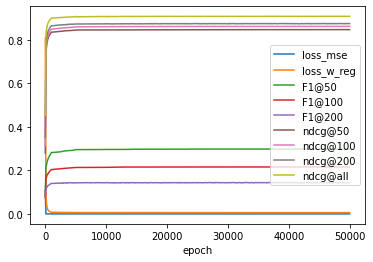

In [43]:
pd.set_option('display.max_rows', 500)
results_df = pd.DataFrame(results)
results_df.groupby(by=['epoch']).mean().plot()
results_df.groupby(by=['epoch']).mean()
# results_df.groupby(by=['epoch']).mean().iloc[-1]

## Quality Check

In [50]:
# select doc_id and k
doc_id = 4
topk = 50

model

LR(
  (emb): Embedding(100, 13776)
)

In [51]:
import colored
from colored import stylize

word_list = dataset.vocab.itos

gt = [word_list[word_idx] for word_idx in np.argsort(weight_ans[doc_id])[::-1][:topk]]
pred = [word_list[word_idx] for word_idx in np.argsort(model.emb.cpu().weight.data[doc_id].numpy())[::-1][:topk]]

print('ground truth')
for word in gt:
    if word in pred:
        print(stylize(word, colored.bg("yellow")), end=' ')
    else:
        print(word, end=' ')

print()
print('\nprediction')
for word in pred:
    if word in gt:
        print(stylize(word, colored.bg("yellow")), end=' ')
    else:
        print(word, end=' ')


ground truth
actress room ann cut warren slapstick speak rent price flesh sailor mel brook fume prewar caruso lanza pavarotti soviet 1941 fujimori 1961 affluent mickey incident butler swirl backlot mutt serpent traitor treacher matriarch vagabond rooney rudolph rick duet 1920 blyth danza metropolitan soprano stalingrad gusto ander erwin pidgeon clyde creation 

prediction
actress ann room cut slapstick warren pay bill theater price bedroom character bacon lower cabin wood jack swap jim mix hurt overboard broadway walk sit fume comedian simmer darker swim nude ian told troy deborah liv hair husband eat fuller speak prison oop pooh fat spike she mel spoke brook 

In [52]:
# raw document
dataset.documents[doc_id]

'this is not the typical mel brooks film .  it was much less slapstick than most of his movies and actually had a plot that was followable .  leslie ann warren made the movie ,  she is such a fantastic ,  under-rated actress .  there were some moments that could have been fleshed out a bit more ,  and some scenes that could probably have been cut to make the room to do so ,  but all in all ,  this is worth the price to rent and see it .  the acting was good overall ,  brooks himself did a good job without his characteristic speaking to directly to the audience .  again ,  warren was the best actor in the movie ,  but  " fume "  and  " sailor "  both played their parts well . '

In [53]:
results = {}
   
scores = np.array(model.emb.weight.data)[doc_id].reshape(1, -1)
true_relevance = train_loader.dataset.weight_ans[doc_id].reshape(1, -1)

results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))

print('NDCG top50', results['ndcg@50'])
print('NDCG top100', results['ndcg@100'])
print('NDCG top200', results['ndcg@200'])
print('NDCG ALL', results['ndcg@all'])


NDCG top50 0.8838474332394813
NDCG top100 0.9114245167819601
NDCG top200 0.9114245167819601
NDCG ALL 0.9218540102680856
